In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize

import string, warnings, urllib3, locale

warnings.filterwarnings('ignore')
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

def nice_axes(ax):
    plt.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.1)
               , ncol = len(df.columns)
               , fancybox = False
               , shadow = True
               , fontsize = 20)

    [spine.set_visible(False) for spine in ax.spines.values()]

    ax.set_yticklabels([int(x) if x > 0 else '' for x in ax.get_yticks()])

    vals = ax.get_xticks()
    ax.tick_params(left = False, bottom = False)
    ax.grid(axis='y', alpha=0.25)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('')

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

In [3]:
url = 'https://es.wikipedia.org/wiki/ISO_3166-2:ES'
comunidades = {}

urllib3.disable_warnings()
http = urllib3.PoolManager()
response = http.request('GET', url)
soup = BeautifulSoup(response.data, 'html.parser')

for i in soup.find_all('tr'):
    if len(i.find_all('td')) == 2:
        k = str(i.find_all('td')[1].find_all('a')[0])
        comunidades[str(i.find_all('td')[0])[11:13]] = k[k.find('title') + 7:k.find('">')]

comunidades 

{'AN': 'Andalucía',
 'AR': 'Aragón',
 'AS': 'Asturias',
 'CN': 'Canarias',
 'CB': 'Cantabria',
 'CM': 'Castilla-La Mancha',
 'CL': 'Castilla y León',
 'CT': 'Cataluña',
 'EX': 'Extremadura',
 'GA': 'Galicia',
 'IB': 'Islas Baleares',
 'RI': 'La Rioja (España)',
 'MD': 'Comunidad de Madrid',
 'MC': 'Región de Murcia',
 'NC': 'Comunidad Foral de Navarra',
 'PV': 'País Vasco',
 'VC': 'Comunidad Valenciana',
 'CE': 'Ceuta',
 'ML': 'Melilla'}

## Poblacion

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review + '.' for review in comunidades.values()), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.Total = poblacion.Total.str.replace('.','').astype(int)

poblacion = poblacion.Total

poblacion

Comunidades y Ciudades Autónomas
Andalucía                     8464411
Aragón                        1329391
Asturias                      1018784
Islas Baleares                1171543
Canarias                      2175952
Cantabria                      582905
Castilla y León               2394918
Castilla-La Mancha            2045221
Cataluña                      7780479
Comunidad Valenciana          5057353
Extremadura                   1063987
Galicia                       2701819
Comunidad de Madrid           6779888
Región de Murcia              1511251
Comunidad Foral de Navarra     661197
País Vasco                    2220504
La Rioja (España)              319914
Ceuta                           84202
Melilla                         87076
Name: Total, dtype: int64

In [5]:
url = 'https://cnecovid.isciii.es/covid19/resources/casos_tecnica_ccaa.csv'
df = pd.read_csv(url)

df = (df
      .assign(ccaa_iso = df.ccaa_iso.map(comunidades))
      .set_index('ccaa_iso')
      .merge(poblacion, left_index=True, right_index=True)
      .reset_index()
      .set_index('fecha')
      .rename(columns = {'index': 'Comunidad'
                         , 'num_casos': 'Casos'
                        }))

df[df.Comunidad == 'Comunidad Valenciana'].tail(15)['Casos']

fecha
2021-02-11    964
2021-02-12    849
2021-02-13    612
2021-02-14    368
2021-02-15    623
2021-02-16    564
2021-02-17    472
2021-02-18    345
2021-02-19    348
2021-02-20    291
2021-02-21    142
2021-02-22    164
2021-02-23    202
2021-02-24    122
2021-02-25      0
Name: Casos, dtype: int64

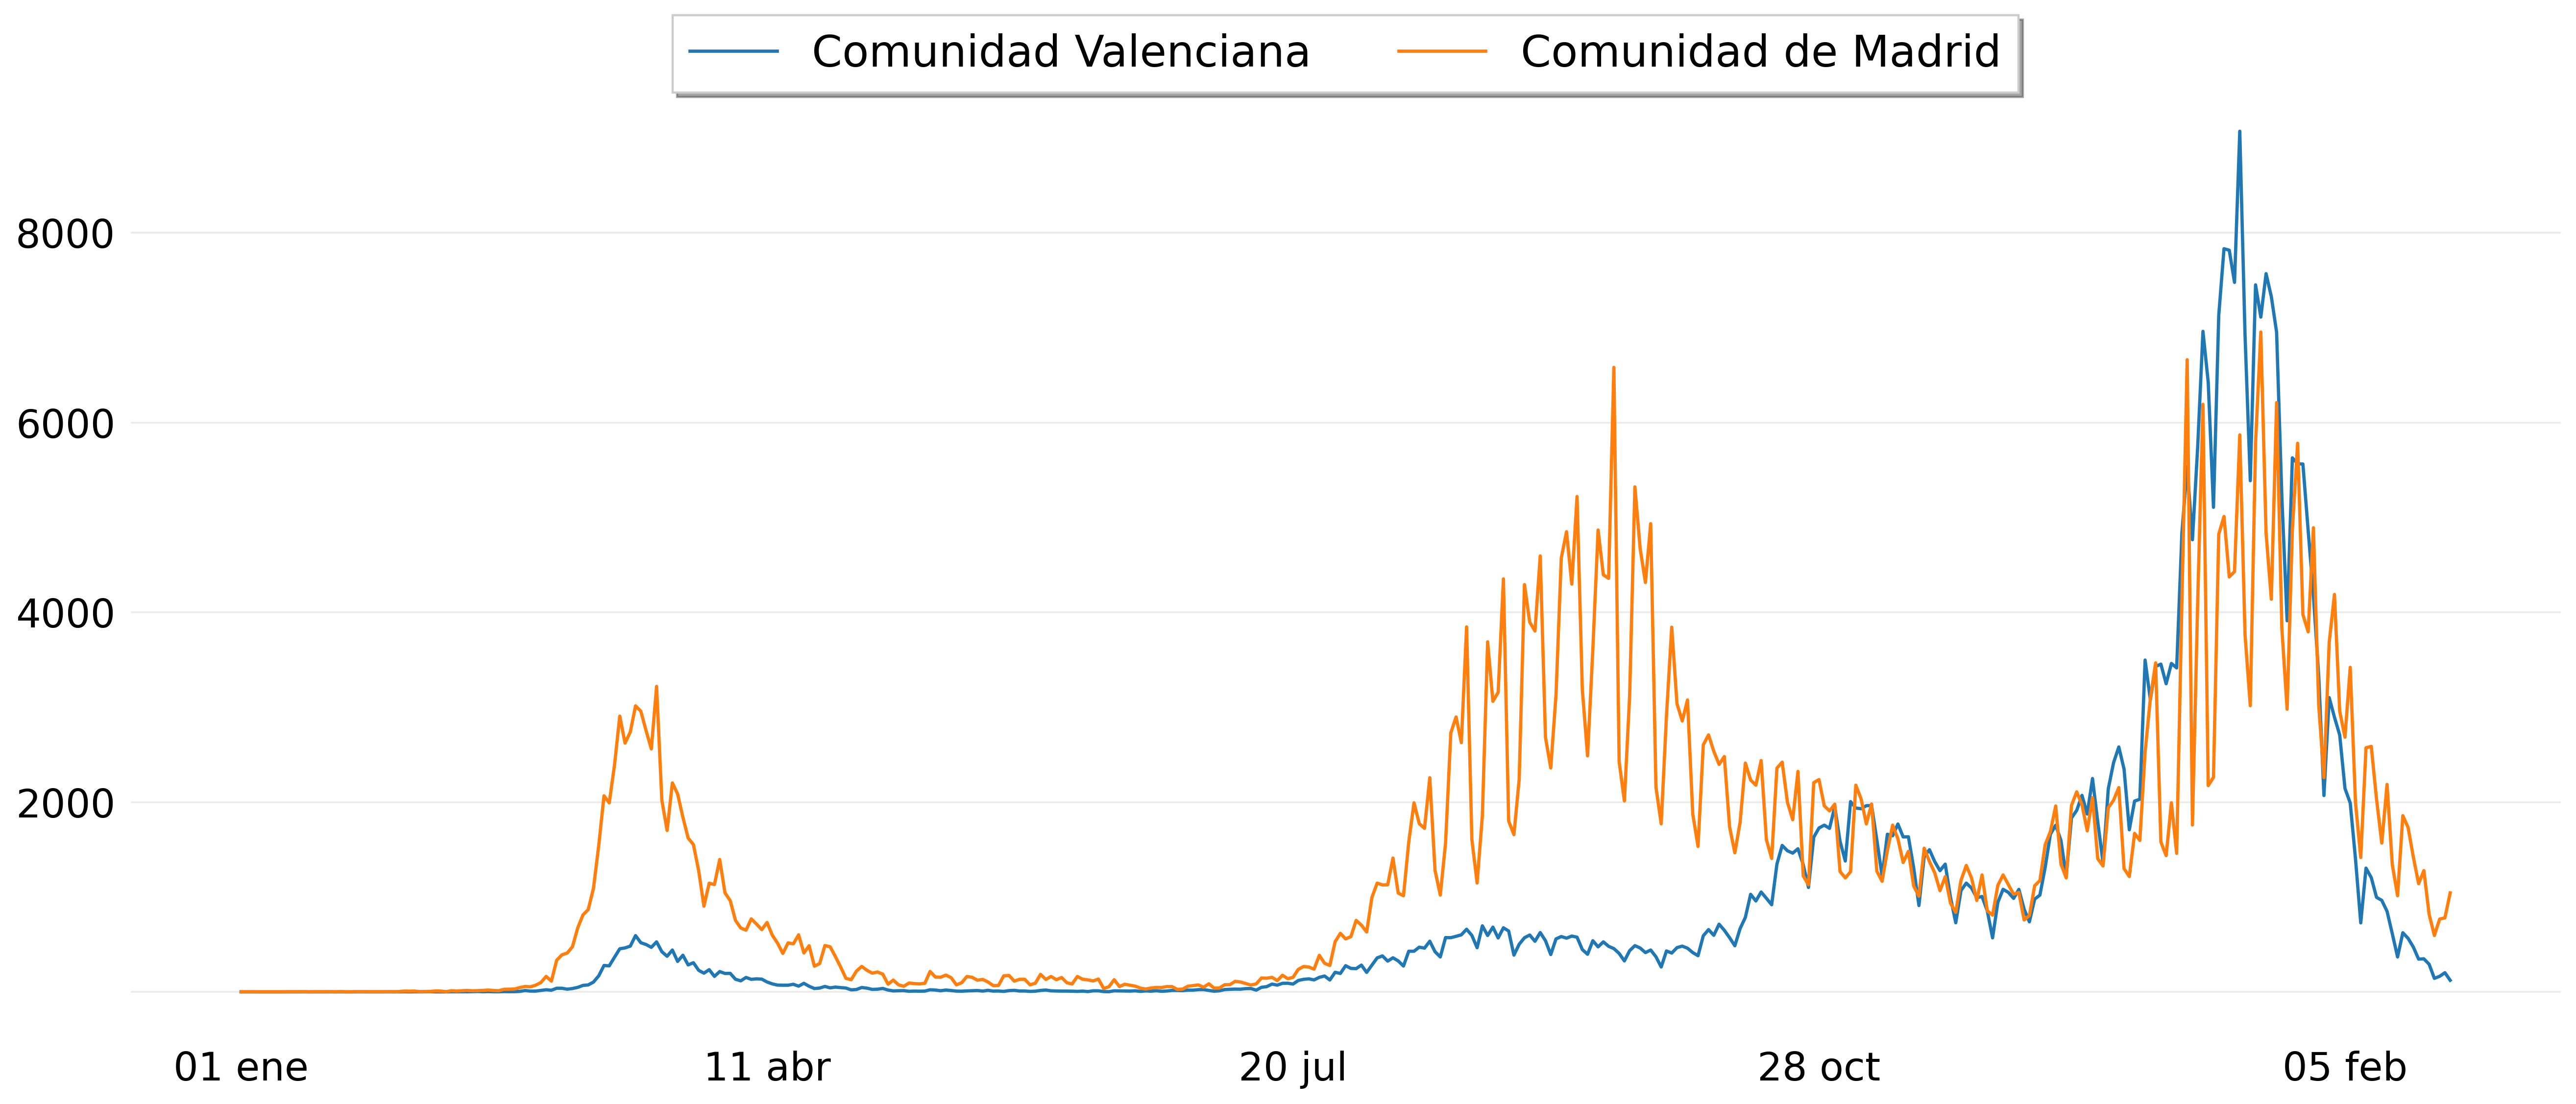

In [6]:
fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

df[df.Comunidad == 'Comunidad Valenciana'][:-1]['Casos'].plot(label = 'Comunidad Valenciana')
df[df.Comunidad == 'Comunidad de Madrid'][:-1]['Casos'].plot(label = 'Comunidad de Madrid')

nice_axes(ax)
plt.show()

In [7]:
df['Incidencia'] = df.Casos / df.Total * 1e5

df = df.pivot(columns='Comunidad', values = 'Incidencia')

df2 = df + df.shift(1) + df.shift(2) + df.shift(3) + df.shift(4) + df.shift(5) + df.shift(6) + df.shift(7) \
        + df.shift(8) + df.shift(9) + df.shift(10) + df.shift(11) + df.shift(12) + df.shift(13)

df2.tail()

Comunidad,Andalucía,Aragón,Asturias,Canarias,Cantabria,Castilla y León,Castilla-La Mancha,Cataluña,Ceuta,Comunidad Foral de Navarra,Comunidad Valenciana,Comunidad de Madrid,Extremadura,Galicia,Islas Baleares,La Rioja (España),Melilla,País Vasco,Región de Murcia
fecha,,,,,,,,,,,,,,,,,,,
2021-02-21,232.514702,244.924180,228.998492,102.024309,157.315515,237.502912,156.706781,238.095881,299.280302,143.830054,179.580108,326.465570,98.215486,184.098195,104.989744,109.404402,403.096146,272.956050,132.076009
2021-02-22,215.407782,226.494688,204.655746,98.991154,146.164469,215.289208,137.589043,223.855112,280.278378,134.453121,157.038672,299.842711,85.527361,165.444095,94.063982,100.026882,392.760347,253.726181,121.356413
2021-02-23,197.213959,208.666976,184.141094,94.487378,133.984097,194.620442,121.649445,212.146322,260.088834,129.159691,137.225936,273.190354,78.478402,149.010722,82.882148,89.711610,375.534016,231.253805,109.908943
2021-02-24,172.569598,190.312707,164.804316,88.375111,123.347715,172.657268,105.367586,194.281098,230.398328,119.933998,119.944168,258.632591,68.891819,133.169542,73.151391,80.646674,351.417153,215.806862,98.262962
2021-02-25,149.260238,170.228323,150.473506,79.597344,107.050034,154.702583,90.894823,175.940324,209.021163,107.834730,100.882814,235.505365,57.331528,115.773855,64.700997,67.830730,312.370803,194.730566,88.072729


In [8]:
df2[:-1].loc[df2[:-1].index.max()].sort_values()

Comunidad
Extremadura                    68.891819
Islas Baleares                 73.151391
La Rioja (España)              80.646674
Canarias                       88.375111
Región de Murcia               98.262962
Castilla-La Mancha            105.367586
Comunidad Foral de Navarra    119.933998
Comunidad Valenciana          119.944168
Cantabria                     123.347715
Galicia                       133.169542
Asturias                      164.804316
Andalucía                     172.569598
Castilla y León               172.657268
Aragón                        190.312707
Cataluña                      194.281098
País Vasco                    215.806862
Ceuta                         230.398328
Comunidad de Madrid           258.632591
Melilla                       351.417153
Name: 2021-02-24, dtype: float64

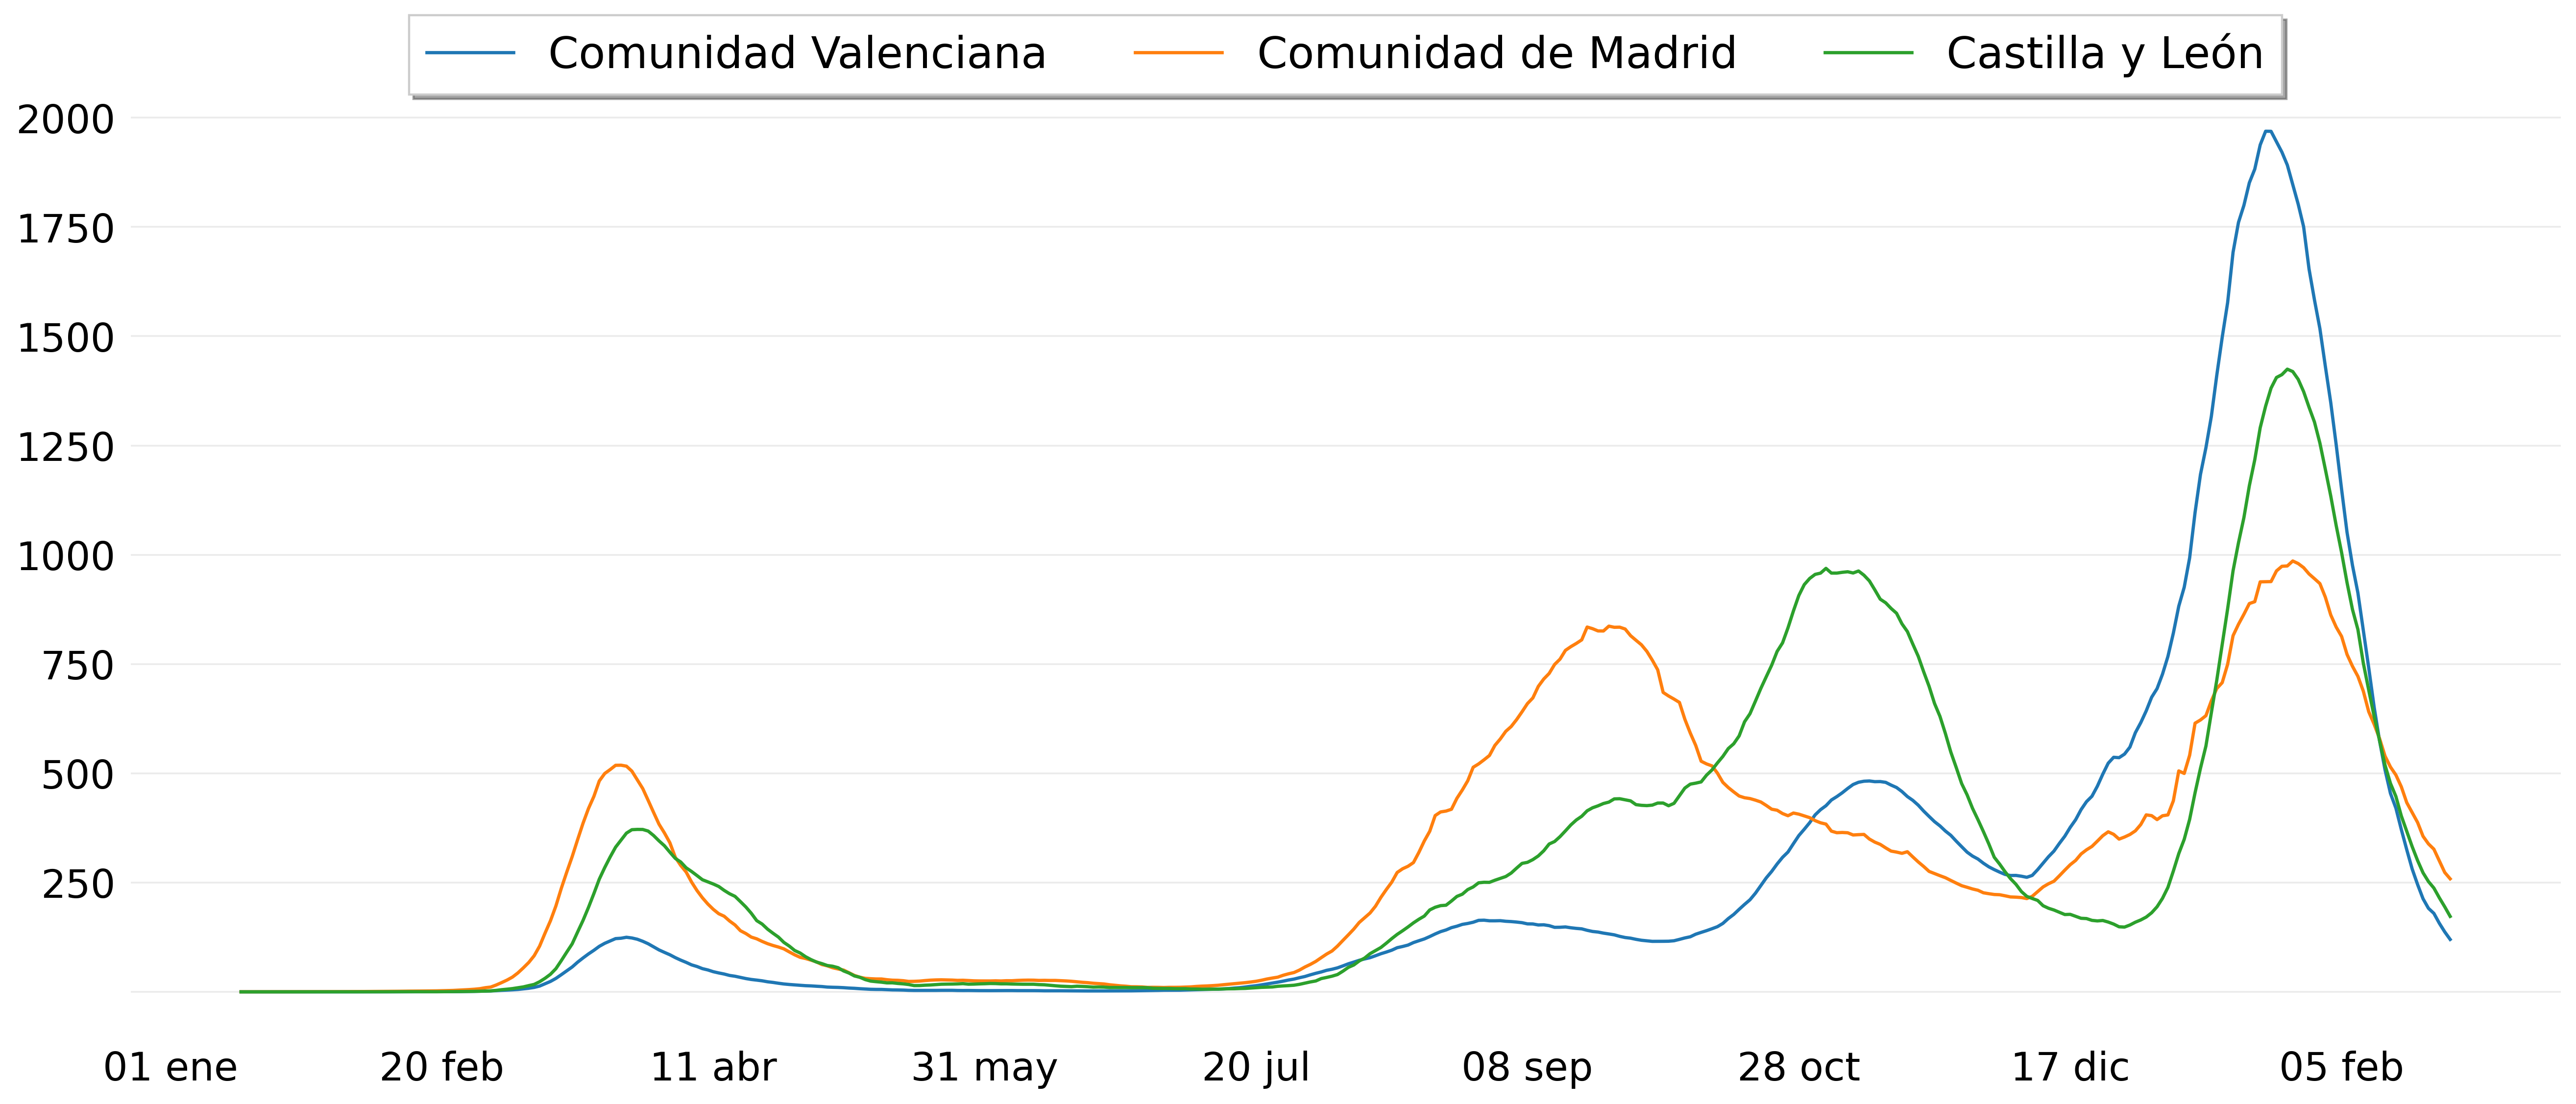

In [9]:
fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

df2[:-1]['Comunidad Valenciana'].plot()
df2[:-1]['Comunidad de Madrid'].plot()
df2[:-1]['Castilla y León'].plot()

nice_axes(ax)
plt.show()